 # Analiza podnebnih podatkov

 ## 1. Uvod

V tem Jupyter notebooku se s pogonom izvede analiza shranjenih podatkov. Analiza se osredotoča na trende globalno izmerjenih temperatur in padavin.
Rezultati so izpisani v obliki grafov in tabel.

 ## 2. Nastavitev okolja

 ### 2.1 Uvoz potrebnih knjižnic

-  Pri pogonu sledeče celice se z uvozom funkcije `instalacija()` iz programa `zahteve_namestitev.py` naložijo vse potrebne knjižnice.

-  Nato iz vseh naloženih knjižnic uvozimo potrebne funkcije.

In [20]:
from zahteve_namestitev import instalacija
instalacija()

import numpy as np                              # Numerične operacije
from tqdm import tqdm                           # Progress bar
from scipy import stats                         # Statistika
from pathlib import Path                        # Poti do datotek
import matplotlib.pyplot as plt                 # Risanje grafov
from matplotlib.patches import FancyArrowPatch  # Risanje puščic
import os                                       # Operacijski sistem
import pandas as pd                             # Pandas
from IPython.display import Image               # Prikaz slike

 ### 2.2 Nastavimo poti do map v uporabi

-  `.cwd()` - Določi trenutni delovni imenik

-  `.mkdir()` - ustvari mapo, če še ne obstaja

In [21]:
Glavna_mapa = Path.cwd()
Podatkovna_baza = Glavna_mapa / "Podatki" / "nepredelani"
Rezultati = Glavna_mapa / "Podatki" / "rezultati"

Podatkovna_baza.mkdir(parents=True, exist_ok=True)
Rezultati.mkdir(parents=True, exist_ok=True)

print(f"""
Glavni imenik:               {Glavna_mapa}
Mapa za nepredelane podatke: {Podatkovna_baza}
Mapa za rezultate:           {Rezultati} """)


Glavni imenik:               c:\Users\jan\Projektna_naloga_UVP
Mapa za nepredelane podatke: c:\Users\jan\Projektna_naloga_UVP\Podatki\nepredelani
Mapa za rezultate:           c:\Users\jan\Projektna_naloga_UVP\Podatki\rezultati 


 ## 3. Definiramo izbrane lokacije

-  Naredimo slovar lokacij na različnih delih Zemlje za analiziranje raznolikih podatkov.
-  Poleg imena jim dodamo njihovo geografsko lokacijo.

   ( latitude / `lat` = širina,  longitude / `lon` = dolžina )"


In [22]:
lokacije = [
    # Severna vzhodna polobla
    {'ime': 'Tokyo', 'lat': 35.68, 'lon': 139.77},
    {'ime': 'Berlin', 'lat': 52.52, 'lon': 13.41},
    {'ime': 'Reykjavik', 'lat': 64.13, 'lon': -21.82},
    {'ime': 'Prag', 'lat': 50.09, 'lon': 14.42},     

    # Severna zahodna polobla
    {'ime': 'Alert', 'lat': 82.50, 'lon': -62.33},
    {'ime': 'Denver', 'lat': 39.74, 'lon': -104.99},
    {'ime': 'Toronto', 'lat': 43.70, 'lon': -79.42},

    # Južna vzhodna polobla
    {'ime': 'Sydney', 'lat': -33.87, 'lon': 151.21},
    {'ime': 'McMurdo_Station', 'lat': -77.85, 'lon': 166.67},
    {'ime': 'Auckland', 'lat': -36.85, 'lon': 174.76},
    
    # Južna zahodna polobla
    {'ime': 'Santiago', 'lat': -33.45, 'lon': -70.67},
    {'ime': 'Lima', 'lat': -12.05, 'lon': -77.03},
]

### 3.1 Prikaz lokacij na globusu

- v datoteki `Globus.py` ustvarimo gif, ki prikazuje izbrane lokacije na vrtečem se globusu.

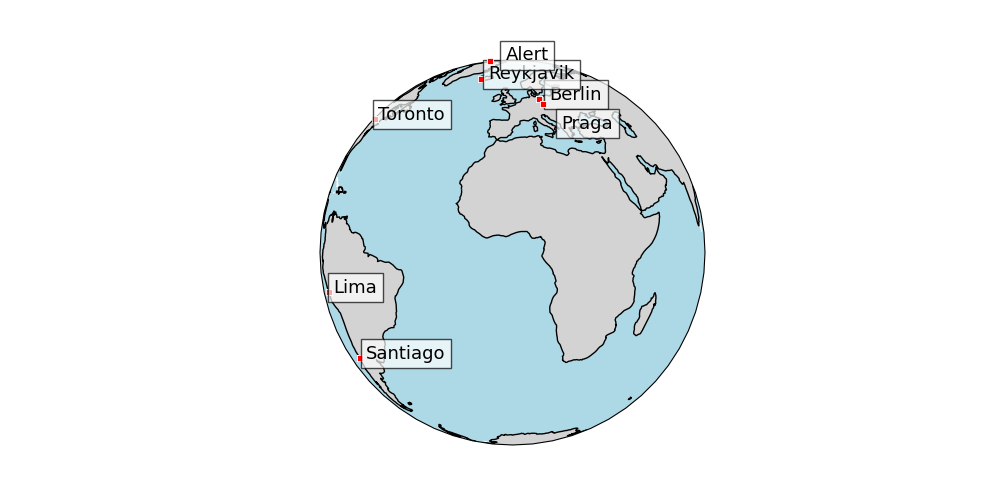

In [23]:
display(Image(filename="globus.gif"))

 ## 4. Analiza podatkov

#### 4.1 PRIPRAVA PODATKOV
-  v spremenljivko `mesta` shranimo imena lokacij iz seznama.

-  ustvarimo prazen slovar `podatki_mest`.

-  `skupaj_prebranih` - beleži število prebranih datotek za feedback.

-  `pot_do_mesta` - ustvari pot do mape posamezne lokacije

-  `vsi_podatki` - prazen seznam za zbiranje DataFrame-ov za trenutno lokacijo

-  `for` zanka doda vse DataFrame za trenutno mesto v `vsi_podatki`

-  `.concat()` - združi več DataFrame-ov v enega

In [24]:
mesta = [mesto['ime'] for mesto in lokacije]

podatki_mest = {}

skupaj_prebranih = 0

for mesto in tqdm(mesta, 
                  desc="Obdelava mest",
                  bar_format="{l_bar}{bar} | {n_fmt}/{total_fmt}"
                  ):
    pot_do_mesta = os.path.join(Podatkovna_baza, mesto)
    vsi_podatki = []
    
    for datoteka in os.listdir(pot_do_mesta):
        if datoteka.endswith(".csv"):
            polna_pot = os.path.join(pot_do_mesta, datoteka)
            df = pd.read_csv(polna_pot)
            vsi_podatki.append(df)
    
    if vsi_podatki:
        zdruzeni_df = pd.concat(vsi_podatki, ignore_index=True)
        podatki_mest[mesto] = zdruzeni_df
        skupaj_prebranih += len(vsi_podatki)
    else:
        print(f"Ni datotek za {mesto}")

print(f"Skupaj prebranih datotek: {skupaj_prebranih}")

Obdelava mest: 100%|██████████ | 12/12

Skupaj prebranih datotek: 784


### 4.2 Računanje povprečne letne temperature
-  Ustvarimo slovarje za shranjevanje razultatov.

- `for` zanka zažene čez podatke vseh mest.

-  `.to_datetime()` - Spremenimo format datuma.

-  Dodamo stolpce za leto in mesec.

-  `letna_povprecja` - Izračunamo povprečno letno temperaturo z združevanjem po letih in preimenujemo stolpec.

-  Shranimo leta in povprečne temperature v slovar.

-  V `leta` in `temperature` shranimo vrednosti.

-  Posebna obdelava za lokacijo Alert zaradi šibkosti podatkov.

-  Znotraj `try` zanke izvedemo linearno regresijo za določitev naklona/trenda in shranimo v slovar trendov.


In [25]:
povprecna_leta = {}
povprecne_temperature = {}
trendi_mest = {}

for mesto, df in podatki_mest.items():
    df = df.rename(columns={
        df.columns[0]: 'Datum',
        df.columns[1]: 'Temperatura'
    })
    
    df['Datum'] = pd.to_datetime(df['Datum'])
    df['Leto'] = df['Datum'].dt.year
    df['Mesec'] = df['Datum'].dt.month
    
    letna_povprecja = df.groupby('Leto')['Temperatura'].mean().reset_index()
    letna_povprecja = letna_povprecja.rename(columns={'Temperatura': 'Povprečje'})
    
    povprecna_leta[mesto] = letna_povprecja['Leto'].values
    povprecne_temperature[mesto] = letna_povprecja['Povprečje'].values
    
    leta = letna_povprecja['Leto'].values
    temperature = letna_povprecja['Povprečje'].values
    
    if mesto == 'Alert':
        mask = ~np.isnan(temperature)
        leta = leta[mask]
        temperature = temperature[mask]
    
    try:
        naklon, odsek, r_value, p_value, std_err = stats.linregress(leta, temperature)
        trendi_mest[mesto] = {
            'naklon': naklon,
            'p_value': p_value,
            'r_value': r_value
        }
    except:
        pass

### 4.3 Tabela trenda povprečne letne temperature

-  Ustvarimo tabelo temperaturnih trendov za lokacije in jih razvrstimo po hitrosti segrevanja.

In [26]:
print("Temperaturni trendi lokacij")
print("=" * 45)
print(f"{'Št':<4} {'Mesto':<20} {'Trend (°C/leto)':<15}")
print("-" * 45)

urejena_mesta = sorted(trendi_mest.items(), key=lambda x: x[1]['naklon'], reverse=True)

for idx, (mesto, podatki) in enumerate(urejena_mesta, 1):
    trend = podatki['naklon']
    print(f"{idx:<4} {mesto:<20} + {trend:<15.4f}")

Temperaturni trendi lokacij
Št   Mesto                Trend (°C/leto)
---------------------------------------------
1    Alert                + 0.0776         
2    Prag                 + 0.0370         
3    Toronto              + 0.0357         
4    McMurdo_Station      + 0.0337         
5    Santiago             + 0.0310         
6    Berlin               + 0.0269         
7    Sydney               + 0.0252         
8    Tokyo                + 0.0244         
9    Reykjavik            + 0.0167         
10   Auckland             + 0.0119         
11   Denver               + 0.0077         
12   Lima                 + 0.0059         


-  ustvarimo še tabeli, ki pokažeta najhitreje in najpočasneje segrevajoče lokacije.

In [27]:
urejena_mesta = sorted(trendi_mest.items(), key=lambda x: x[1]['naklon'], reverse=True)

print("\n Najhitrejše segrevanje:")
print("-" * 40)
for idx, (mesto, podatki) in enumerate(urejena_mesta[:3], 1):
    trend = podatki['naklon']
    print(f"{idx}. {mesto:<18} +{trend:.4f} °C/leto")

# Izpis 3 najpočasneje segrevajočih se mest (najbolj se ohlajajo)
print("\n Najpočasnejše segrevanje:")
print("-" * 40)
for idx, (mesto, podatki) in enumerate(urejena_mesta[-3:], 1):
    trend = podatki['naklon']
    print(f"{idx}. {mesto:<18} {trend:+.4f} °C/leto")


 Najhitrejše segrevanje:
----------------------------------------
1. Alert              +0.0776 °C/leto
2. Prag               +0.0370 °C/leto
3. Toronto            +0.0357 °C/leto

 Najpočasnejše segrevanje:
----------------------------------------
1. Auckland           +0.0119 °C/leto
2. Denver             +0.0077 °C/leto
3. Lima               +0.0059 °C/leto


### Dodatno:  Razvrščanje lokacij po zanesljivosti/ujemanju s podatki: R²

-  Ustvarimo tabelo, ki pokaže, za katere lokacije lahko najbolj zanesljivo določimo ali se segrevajo.

-  Večji R² -> Bolj zanesljivi rezultati.

In [28]:
po_zanesljivosti = sorted(
    trendi_mest.items(), 
    key = lambda x: x[1]['r_value']**2, 
    reverse=True
)

print("Lokacije razvrščene po zanesljivosti/ujemanju s podatki: R²")
print("=" *50)
print(f"                   {'Trend(°C/leto)':>15} {'R²':>8}")
print("-" *50)
for rank, (city, data) in enumerate(po_zanesljivosti, 1):
    r_squared = data['r_value']**2
    trend = data['naklon']
    
    print(f"{rank:2d}. {city:18}  {trend:<8.4f}     {r_squared:8.4f}")

Lokacije razvrščene po zanesljivosti/ujemanju s podatki: R²
                    Trend(°C/leto)       R²
--------------------------------------------------
 1. Sydney              0.0252         0.7150
 2. Tokyo               0.0244         0.5610
 3. Santiago            0.0310         0.5303
 4. Prag                0.0370         0.4857
 5. Toronto             0.0357         0.3751
 6. Berlin              0.0269         0.3495
 7. Reykjavik           0.0167         0.2384
 8. Alert               0.0776         0.1907
 9. Auckland            0.0119         0.0973
10. Denver              0.0077         0.0499
11. McMurdo_Station     0.0337         0.0368
12. Lima                0.0059         0.0106


### 4.4 Graf povprečnih letnih temperatur za lokacije

 - Nastavimo velikost grafa in barve.

 - Znotraj `for` zanke ustvarimo graf vsake lokacije ( `.plot()` ).

 - Če so preskoki med leti preveliki, jih povežemo s črtkano črto.

 - Nastavimo naslov in osi grafa, ter spremenljivke za določanje povezave z imeni.

 - Lokacije razvrstimo po zadnji temperaturi in jim določimo pozicijo desno od grafa. Da se ne bodo prekrivala določimo minimalni razmik.

 - Nato znotraj `for` zanke določimo pozicijo vsake izmed lokacij.

 - Dodamo imena in vsakemu pripadajočo barvo. Narišemo še puščico od zadnje izmerjene temperature do imena.

 - Prilagodimo meje grafa in ga shranimo v mapo `rezultati`.

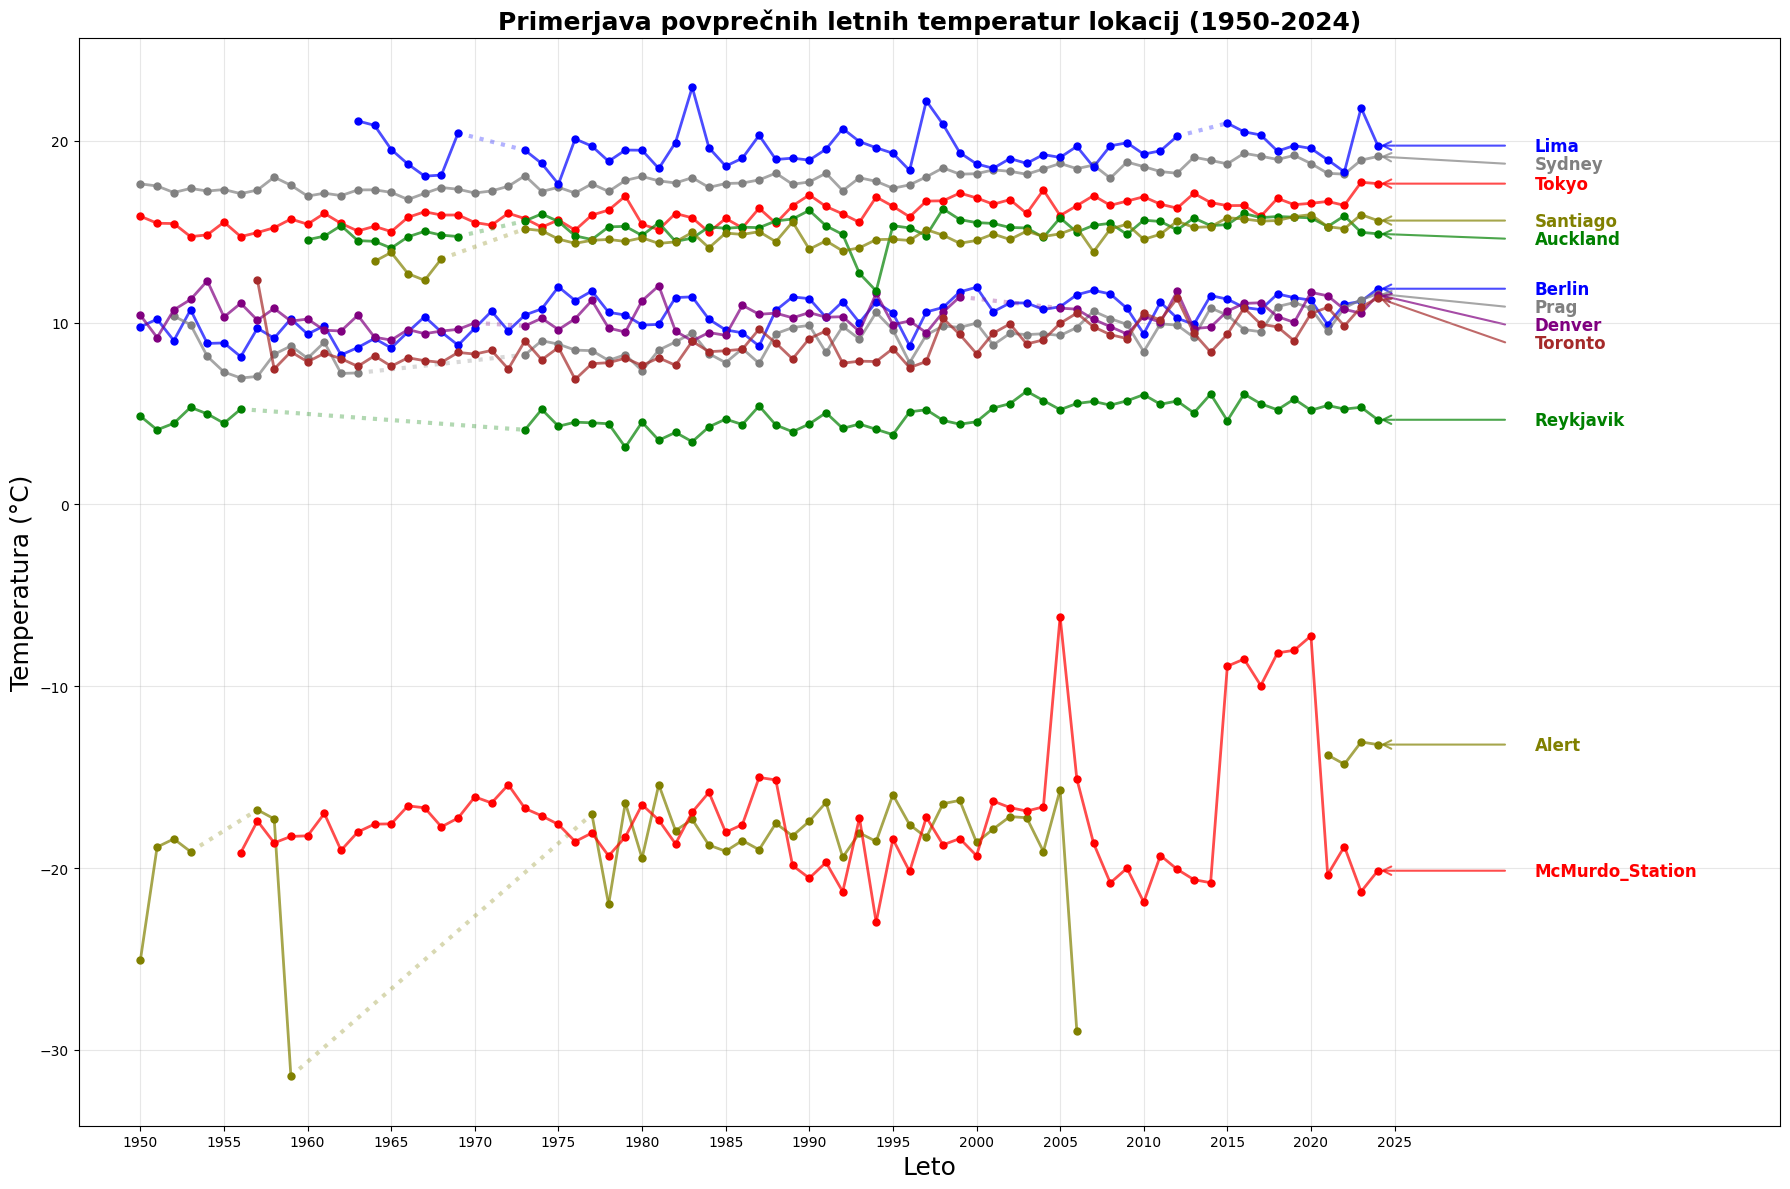

In [29]:
plt.figure(figsize=(18, 12))

barve = ['red', 'blue', 'green', 'gray', 'olive', 'purple',
        'brown', 'gray', 'red',  'green', 'olive', 'blue']

for i, (mesto, leta) in enumerate(povprecna_leta.items()):
    temperature = povprecne_temperature[mesto]
    barva = barve[i % len(barve)]
    
    plt.plot(leta, temperature, 
             color=barva, 
             linewidth=2,
             marker='o',
             markersize=5,
             markerfacecolor=barva,
             markeredgecolor=barva,
             markeredgewidth=1,
             linestyle='None')
    
    for j in range(len(leta) - 1):
        razlika_let = leta[j + 1] - leta[j]
        if razlika_let <= 2:
            plt.plot([leta[j], leta[j + 1]], 
                     [temperature[j], temperature[j + 1]],
                     color=barva,
                     linewidth=2,
                     alpha=0.7)
        else:
            plt.plot([leta[j], leta[j + 1]], 
                     [temperature[j], temperature[j + 1]],
                     color=barva,
                     linewidth=3,
                     alpha=0.3,
                     linestyle=':')

plt.title('Primerjava povprečnih letnih temperatur lokacij (1950-2024)', fontsize=18, fontweight='bold')
plt.xlabel('Leto', fontsize=18)
plt.ylabel('Temperatura (°C)', fontsize=18)
plt.grid(True, alpha=0.3)

plt.xticks(np.arange(1950, 2026, 5))

zadnje_temperature = {}
for mesto in povprecna_leta.keys():
    leta = povprecna_leta[mesto]
    temperature = povprecne_temperature[mesto]
    zadnje_leto_idx = np.argmax(leta)
    zadnje_temperature[mesto] = (leta[zadnje_leto_idx], temperature[zadnje_leto_idx])

razvrscena_mesta = sorted(zadnje_temperature.items(), key=lambda x: x[1][1], reverse=True)

ax = plt.gca()
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

desna_meja = x_lim[1] + (x_lim[1] - x_lim[0]) * 0.05
text_margin = (x_lim[1] - x_lim[0]) * 0.02

min_razmik = 1.0

y_positions = []
current_y = None

for i, (mesto, (leto, temp)) in enumerate(razvrscena_mesta):
    if i == 0:
        y_positions.append(temp)
        current_y = temp
    else:
        # Prekrivanje
        if temp > current_y - min_razmik:
            new_y = current_y - min_razmik
            y_positions.append(new_y)
            current_y = new_y
        else:
            y_positions.append(temp)
            current_y = temp

for i, ((mesto, (leto, temp)), y_text) in enumerate(zip(razvrscena_mesta, y_positions)):
    barva_idx = list(povprecna_leta.keys()).index(mesto) % len(barve)
    barva = barve[barva_idx]
    
    plt.text(desna_meja + text_margin, y_text, mesto, 
             color=barva, fontsize=12, fontweight='bold',
             verticalalignment='center', horizontalalignment='left')
    
    arrow = FancyArrowPatch(
        (leto, temp),
        (desna_meja, y_text),
        arrowstyle='<-',
        color=barva,
        mutation_scale=15,
        linewidth=1.5,
        alpha=0.7,
        linestyle='-'
    )
    ax.add_patch(arrow)

plt.xlim(x_lim[0], desna_meja + (x_lim[1] - x_lim[0]) * 0.2)

plt.tight_layout()

plt.savefig('Podatki/rezultati/primerjava_vseh_mest.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.5 Graf trendov letnih temperatur

-  Določimo nastavitve grafa, nakar v `for` zanki vanj dodamo trendne črte za vsako lokacijo.

-  Nastavimo ime in osi grafa. Na desni pa dodamo imena lokacij, ponovno razvrščenih po zdanji izmerjeni temperaturi in jih povežemo s pripadajočo črto na grafu.

-  Graf ponovno shranimo v mapo `rezultati`.

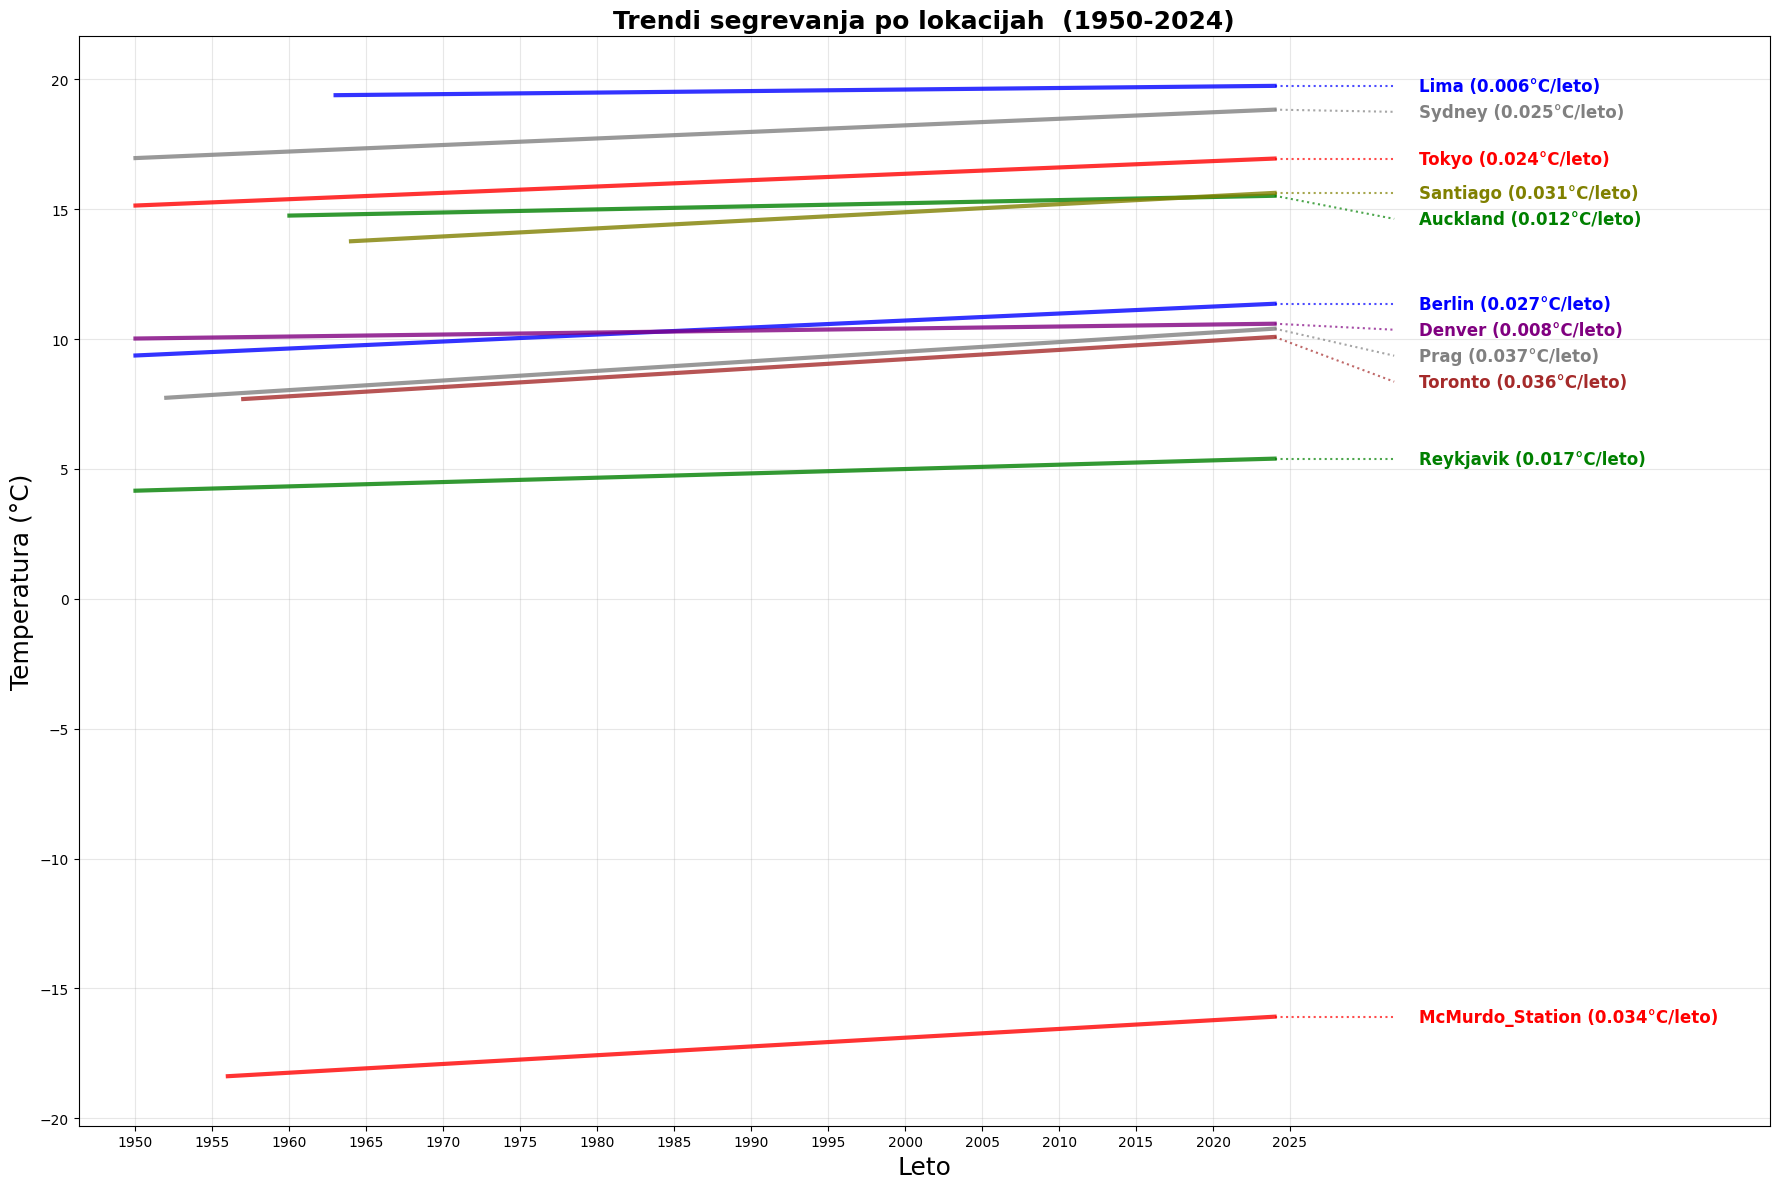

In [30]:
plt.figure(figsize=(18, 12))

barve = ['red', 'blue', 'green', 'gray', 'olive', 'purple',
        'brown', 'gray', 'red',  'green', 'olive', 'blue']

for i, (mesto, leta) in enumerate(povprecna_leta.items()):
    temperature = povprecne_temperature[mesto]
    barva = barve[i % len(barve)]
    
    if len(leta) > 1:
        naklon = trendi_mest[mesto]['naklon']
        odsek = stats.linregress(leta, temperature).intercept
        
        x_min, x_max = min(leta), max(leta)
        x_range = np.array([x_min, x_max])
        y_trend = naklon * x_range + odsek
        
        plt.plot(x_range, y_trend, color=barva, linewidth=3, alpha=0.8)

plt.title('Trendi segrevanja po lokacijah  (1950-2024)', fontsize=18, fontweight='bold')
plt.xlabel('Leto', fontsize=18)
plt.ylabel('Temperatura (°C)', fontsize=18)
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(1950, 2026, 5))

razvrscena_mesta = sorted(trendi_mest.items(), key=lambda x: x[1]['naklon'], reverse=True)

ax = plt.gca()
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

desna_meja = x_lim[1] + (x_lim[1] - x_lim[0]) * 0.05
text_margin = (x_lim[1] - x_lim[0]) * 0.02

min_razmik = 1.0

y_positions = []
current_y = y_lim[1]

koncne_vrednosti = {}
for mesto in povprecna_leta.keys():
    leta = povprecna_leta[mesto]
    temperature = povprecne_temperature[mesto]
    if len(leta) > 0:
        naklon = trendi_mest[mesto]['naklon']
        odsek = stats.linregress(leta, temperature).intercept
        zadnje_leto = max(leta)
        koncne_vrednosti[mesto] = (zadnje_leto, naklon * zadnje_leto + odsek)

razvrscena_mesta = sorted(koncne_vrednosti.items(), key=lambda x: x[1][1], reverse=True)

for i, (mesto, (leto, koncna_vrednost)) in enumerate(razvrscena_mesta):
    if i == 0:
        y_positions.append(koncna_vrednost)
        current_y = koncna_vrednost
    else:
        if koncna_vrednost > current_y - min_razmik:
            new_y = current_y - min_razmik
            y_positions.append(new_y)
            current_y = new_y
        else:
            y_positions.append(koncna_vrednost)
            current_y = koncna_vrednost

for i, ((mesto, (leto, koncna_vrednost)), y_text) in enumerate(zip(razvrscena_mesta, y_positions)):
    barva_idx = list(povprecna_leta.keys()).index(mesto) % len(barve)
    barva = barve[barva_idx]
    
    naklon = trendi_mest[mesto]['naklon']
    plt.text(desna_meja + text_margin, y_text, f"{mesto} ({naklon:.3f}°C/leto)", 
             color=barva, fontsize=12, fontweight='bold',
             verticalalignment='center', horizontalalignment='left')
    
    plt.plot([leto, desna_meja], [koncna_vrednost, y_text], 
             color=barva, linewidth=1.5, alpha=0.7, linestyle=':')

plt.xlim(x_lim[0], desna_meja + (x_lim[1] - x_lim[0]) * 0.3)
plt.tight_layout()

plt.savefig('Podatki/rezultati/trendi_segrevanja_vseh_mest.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.6 Računanje ekstremov in prikaz v tabeli

-  Nastavimo ime tabele in imena vrednosti.

-  Za vsako mesto/lokacijo, ki jih sortiramo po letih s funkcijo `.quantile` določimo ali vrednost spada pod podnebni ekstrem. Ekstreme definiramo kot preseg 90% ostalih temperaturnih vrednosti ali pa tiste, ki padejo pod 10% ostalih vrednosti. Shranimo jih v svoje spremenljivke.

-  Če je dovolj podatkov, z `.linregress()` izračunamo trende vsakih izmed ekstremov.

-  Izračunamo še `Povprečno število ekstremno hladnih/vročih dni na leto`.

-  Vrednosti v tabeli z formatiranjem omejimo na 3 decimalke in jih nato zapišemo v tabelo.

In [31]:
print("Analiza trendov ekstremno hladnih in ekstremno vročih dni")
print("=" * 90)
print(f"{'Št':<4} {'Mesto':<18} {'Povpr. hladnih':<18} {'Trend hladnih':<15} {'Povpr. vročih':<18} {'Trend vročih':<15}")
print("-" * 90)

for idx, (mesto, df) in enumerate(podatki_mest.items(), 1):
    df['Datum'] = pd.to_datetime(df['time'])
    df['Leto'] = df['Datum'].dt.year
    
    ekstremni_hladni = []
    ekstremni_vroci = []
    leta = sorted(df['Leto'].unique())
    
    for leto in leta:
        df_leto = df[df['Leto'] == leto]
        
        if len(df_leto) > 0:
            perc90_min = df_leto['tmin'].quantile(0.1)
            perc90_max = df_leto['tmax'].quantile(0.9)
            
            hladni = df_leto[df_leto['tavg'] < perc90_min].shape[0]
            vroci = df_leto[df_leto['tavg'] > perc90_max].shape[0]
            
            ekstremni_hladni.append(hladni)
            ekstremni_vroci.append(vroci)
    
    if len(ekstremni_hladni) >= 2:
        try:
            trend_hladni = stats.linregress(leta[-len(ekstremni_hladni):], ekstremni_hladni).slope
        except:
            trend_hladni = 0.0
    else:
        trend_hladni = 0.0
        
    if len(ekstremni_vroci) >= 2:
        try:
            trend_vroci = stats.linregress(leta[-len(ekstremni_vroci):], ekstremni_vroci).slope
        except:
            trend_vroci = 0.0
    else:
        trend_vroci = 0.0
    
    povprecno_hladni = sum(ekstremni_hladni)/len(ekstremni_hladni)
    povprecno_vroci = sum(ekstremni_vroci)/len(ekstremni_vroci)
    
    def format_stevilo(x):
        if isinstance(x, (int, float)):
            formatted = f"{x:.3f}".rstrip('0').rstrip('.')
            return formatted if formatted != '' else '0'
        return str(x)
    
    print(f"{idx:<4} {mesto:<18} {format_stevilo(povprecno_hladni):<18} {format_stevilo(trend_hladni):<15} {format_stevilo(povprecno_vroci):<18} {format_stevilo(trend_vroci):<15}")

print("=" * 90)
print("Opomba: Enote za trende: (dnevi/leto); Povpr. hladnih/vročih = Povprečno število ekstremno hladnih/vročih dni na leto")

Analiza trendov ekstremno hladnih in ekstremno vročih dni
Št   Mesto              Povpr. hladnih     Trend hladnih   Povpr. vročih      Trend vročih   
------------------------------------------------------------------------------------------
1    Tokyo              1.8                0.023           0.653              0.002          
2    Berlin             17.413             -0.046          4.173              -0.028         
3    Reykjavik          10.678             -0.028          1.661              -0.007         
4    Prag               14.734             -0.013          0.984              0.008          
5    Alert              5.945              0.044           5.782              0.069          
6    Denver             10.088             -0.009          0                  0              
7    Toronto            15.809             -0.004          2.118              -0.022         
8    Sydney             0.04               0.001           0.987              -0.014         
9    

### 4.7 Grafični prikaz povprečnega števila ekstremno hladnih dni v letu

-  Nastavimo velikost grafa in ponovno izračunamo ekstremno hladne dni po letih.

-  Za vsako mesto izračunamo 10. percentil minimalnih temperatur in shranimo število dni, kjer je povprečna temperatura nižja.

-  Uporabimo `slope, intercept, _, _, _ = stats.linregress(leta_filtered, ekstremni_hladni)`, da izračunamo linearni trend hladnih dni. Shranimo ga v slovar s trendi in ga narišemo na graf.

-  Določimo še ime grafa in osi, ter legendo z imeni lokacij.

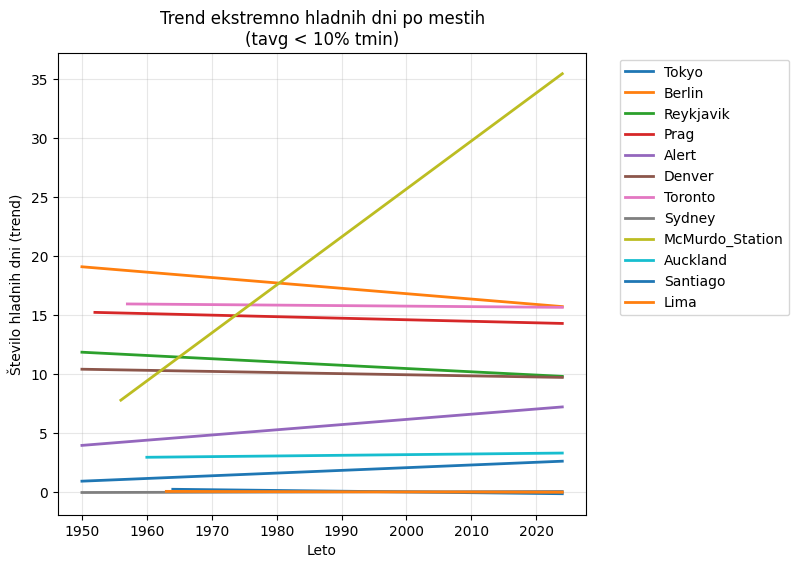

In [32]:
trendi_hladni = {}

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)

for mesto, df in podatki_mest.items():
    df['Datum'] = pd.to_datetime(df['time'])
    df['Leto'] = df['Datum'].dt.year
    
    ekstremni_hladni = []
    leta = sorted(df['Leto'].unique())
    
    for leto in leta:
        df_leto = df[df['Leto'] == leto]
        if len(df_leto) > 0:
            perc10_min = df_leto['tmin'].quantile(0.1)
            hladni = df_leto[df_leto['tavg'] < perc10_min].shape[0]
            ekstremni_hladni.append(hladni)
    
    if len(ekstremni_hladni) >= 2:

        leta_filtered = leta[-len(ekstremni_hladni):]
        slope, intercept, _, _, _ = stats.linregress(leta_filtered, ekstremni_hladni)
        
        trendi_hladni[mesto] = slope

        # Prikaz SAMO trendne črte
        plt.plot(leta_filtered, intercept + slope * np.array(leta_filtered), 
                '-', linewidth=2, label=f'{mesto}')

plt.title('Trend ekstremno hladnih dni po mestih\n(tavg < 10% tmin)')
plt.xlabel('Leto')
plt.ylabel('Število hladnih dni (trend)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.savefig('Podatki/rezultati/trend_ekstremno_hladnih_dni.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.8 Tabelni prikaz trendov hladnih ekstremov lokacij

-  Tabelo začnemo z imenom, ter za ločitev uporabljamo `print("=/-" * številka)`.

-  Prvo narišemo tabelo lokacij, kjer število ekstremno hladnih dni narašča.

-  Naraščanje opredelimo glede na predznak trenda/naklona in jih sortiramo po vrednostih od najhitreje do najpočasneje naraščajoče lokacije.

-  Preverimo obstoj lokacij z naraščajočim trendom in jih zapišemo v tabelo.

-  Nato na isti način ustvarimo še tabelo za lokacije s padajočim številom ekstremno hladnih dni in tabelo za lokacije brez spremembe v številu ekstremno hladnih dni, če ta obstajajo.

In [33]:
print("Trendi ekstremno hladnih dni (tavg < 90% tmin)")
print("=" * 50)

print("\nLokacije z naraščajočim številom ekstremno hladnih dni:")
print("-" * 50)

narascajoci_hladni = [(mesto, trend) for mesto, trend in trendi_hladni.items() if trend > 0]
narascajoci_hladni_sorted = sorted(narascajoci_hladni, key=lambda x: x[1], reverse=True)

if narascajoci_hladni_sorted:
    for mesto, trend in narascajoci_hladni_sorted:
        print(f"{mesto:<20} +{trend:.3f}{'':<15}")
else:
    print("Ni lokacij z naraščajočim trendom")

print("\nLokacije z padajočim številom ekstremno hladnih dni:")
print("-" * 50)

padajoci_hladni = [(mesto, trend) for mesto, trend in trendi_hladni.items() if trend < 0]
padajoci_hladni_sorted = sorted(padajoci_hladni, key=lambda x: x[1])

if padajoci_hladni_sorted:
    for mesto, trend in padajoci_hladni_sorted:
        print(f"{mesto:<20} {trend:.3f}{'':<16}")
else:
    print("Ni mest s padajočim trendom")

print("\nLokacije brez sprememb v številu ekstremno hladnih dni:")
print("-" * 50)

stabilni_hladni = [mesto for mesto, trend in trendi_hladni.items() if trend == 0]

if stabilni_hladni:
    for mesto in stabilni_hladni:
        print(f"{mesto:<20} 0.000{'':<16}")
else:
    print("Ni mest brez sprememb")

Trendi ekstremno hladnih dni (tavg < 90% tmin)

Lokacije z naraščajočim številom ekstremno hladnih dni:
--------------------------------------------------
McMurdo_Station      +0.406               
Alert                +0.044               
Tokyo                +0.023               
Auckland             +0.006               
Sydney               +0.001               

Lokacije z padajočim številom ekstremno hladnih dni:
--------------------------------------------------
Berlin               -0.046                
Reykjavik            -0.028                
Prag                 -0.013                
Denver               -0.009                
Santiago             -0.006                
Toronto              -0.004                
Lima                 -0.001                

Lokacije brez sprememb v številu ekstremno hladnih dni:
--------------------------------------------------
Ni mest brez sprememb


### 4.9 Grafični prikaz povprečnega števila ekstremno vročih dni v letu

-  Risanja grafa za prikaz povprečnega števila ekstremno vročih dni v letu se lotimo enako kot grafa povprečnega števila ekstremno hladnih dni v letu.

-  Razlika od grafa prej je le v tem, da tukaj računamo ekstremno vroče dni kot tiste, kadar povprečna dnevna temperatura presega 90. percentil maksimalne temperature dni tistega leta.

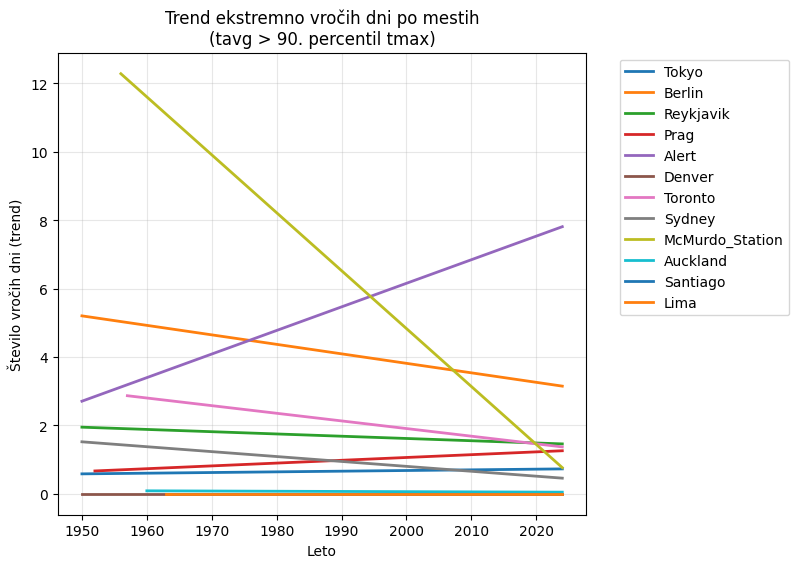

In [34]:
trendi_vroci = {}

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 2)

for mesto, df in podatki_mest.items():
    df['Datum'] = pd.to_datetime(df['time'])
    df['Leto'] = df['Datum'].dt.year
    
    ekstremni_vroci = []
    leta = sorted(df['Leto'].unique())
    
    for leto in leta:
        df_leto = df[df['Leto'] == leto]
        if len(df_leto) > 0:
            perc90_max = df_leto['tmax'].quantile(0.9)
            vroci = df_leto[df_leto['tavg'] > perc90_max].shape[0]
            ekstremni_vroci.append(vroci)
    
    if len(ekstremni_vroci) >= 2:
        leta_filtered = leta[-len(ekstremni_vroci):]
        slope, intercept, _, _, _ = stats.linregress(leta_filtered, ekstremni_vroci)
        
        trendi_vroci[mesto] = slope

        plt.plot(leta_filtered, intercept + slope * np.array(leta_filtered), 
                '-', linewidth=2, label=f'{mesto}')

plt.title('Trend ekstremno vročih dni po mestih\n(tavg > 90. percentil tmax)')
plt.xlabel('Leto')
plt.ylabel('Število vročih dni (trend)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.savefig('Podatki/rezultati/trend_ekstremno_vrocih_dni.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.10 Tabelni prikaz trendov vročih ekstremov lokacij

-  Tudi tabelo trendov vročih ekstremov lokacij ustvarimo na enak način kot tabelo trendov hladnih ekstremov lokacij.

In [35]:
print("Trendi ekstremno vročih dni (tavg > 90% tmax)")
print("=" * 50)

print("\nLokacije z naraščajočim številom ekstremno vročih dni:")
print("-" * 50)

narasajoci_vroci = [(mesto, trend) for mesto, trend in trendi_vroci.items() if trend > 0]
narasajoci_vroci_sorted = sorted(narasajoci_vroci, key=lambda x: x[1], reverse=True)

if narasajoci_vroci_sorted:
    for mesto, trend in narasajoci_vroci_sorted:
        print(f"{mesto:<20} +{trend:.3f}{'':<15}")
else:
    print("Ni mest z naraščajočim trendom")

print("\nLokacije z padajočim številom ekstremno vročih dni:")
print("-" * 50)

padajoci_vroci = [(mesto, trend) for mesto, trend in trendi_vroci.items() if trend < 0]
padajoci_vroci_sorted = sorted(padajoci_vroci, key=lambda x: x[1])

if padajoci_vroci_sorted:
    for mesto, trend in padajoci_vroci_sorted:
        print(f"{mesto:<20} {trend:.3f}{'':<16}")
else:
    print("Ni mest s padajočim trendom")

print("\nLokacije brez sprememb v številu ekstremno vročih dni:")
print("-" * 50)

stabilni_vroci = [mesto for mesto, trend in trendi_vroci.items() if trend == 0]

if stabilni_vroci:
    for mesto in stabilni_vroci:
        print(f"{mesto:<20} 0.000{'':<16}")
else:
    print("Ni mest brez sprememb")

Trendi ekstremno vročih dni (tavg > 90% tmax)

Lokacije z naraščajočim številom ekstremno vročih dni:
--------------------------------------------------
Alert                +0.069               
Prag                 +0.008               
Tokyo                +0.002               

Lokacije z padajočim številom ekstremno vročih dni:
--------------------------------------------------
McMurdo_Station      -0.169                
Berlin               -0.028                
Toronto              -0.022                
Sydney               -0.014                
Reykjavik            -0.007                
Auckland             -0.001                

Lokacije brez sprememb v številu ekstremno vročih dni:
--------------------------------------------------
Denver               0.000                
Santiago             0.000                
Lima                 0.000                


### 4.11 Stolpični diagram povprečne količine padavin za lokacije (1950 - 2024)

-  Ustvarimo seznam za shranjevanje povprečnih količin padavin.

-  Znotraj zanke izračunamo povprečno količino dežja in snega za lokacijo, ter jih dodamo v slovar.

-  Slovar pretvorimo v DataFrame.

-  Ustvarimo stolpični diagram in dva stolpca, za povprečno količino dežja in povprečno količino snega. Določimo še ime in osi diagrama.

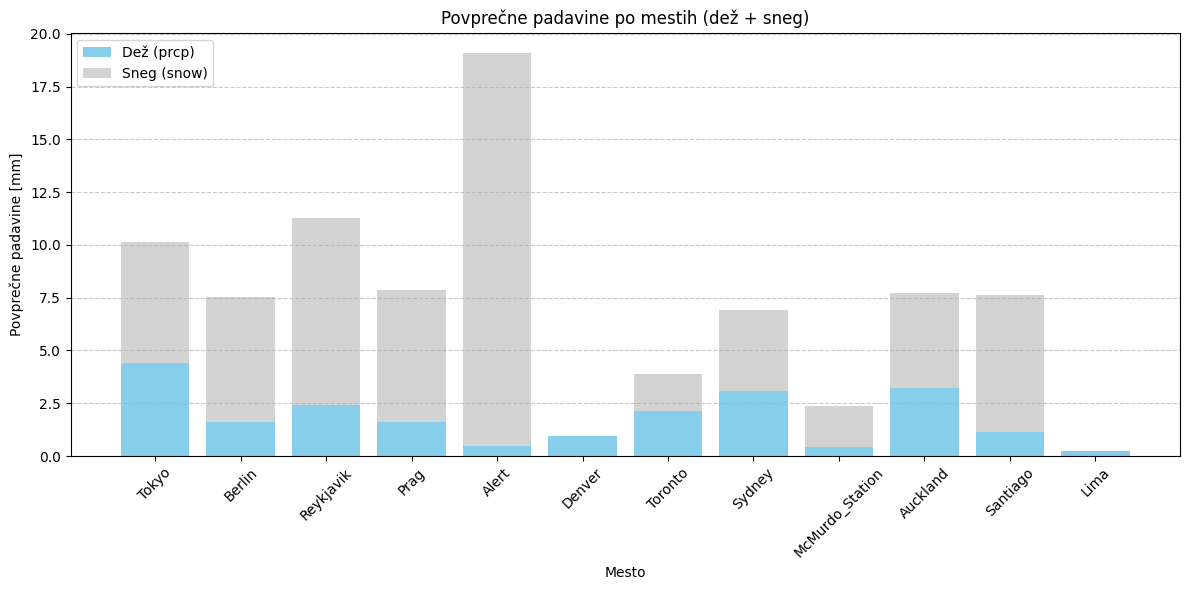

In [36]:
povprecne_padavine = []

for mesto, df in podatki_mest.items():
    df['Datum'] = pd.to_datetime(df['Datum'])
    prcp_avg = df['prcp'].mean()
    snow_avg = df['snow'].mean()
    povprecne_padavine.append({
        "Mesto": mesto,
        "Prcp": prcp_avg,
        "Snow": snow_avg
    })

df_povprecne = pd.DataFrame(povprecne_padavine)

plt.figure(figsize=(12,6))
plt.bar(df_povprecne['Mesto'], df_povprecne['Prcp'], label='Dež (prcp)', color='skyblue')
plt.bar(df_povprecne['Mesto'], df_povprecne['Snow'], bottom=df_povprecne['Prcp'], 
        label='Sneg (snow)', color='lightgray')

plt.ylabel("Povprečne padavine [mm]")
plt.xlabel("Mesto")
plt.title("Povprečne padavine po mestih (dež + sneg)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Podatki/rezultati/povprecne_padavine.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.12 Grafični prikaz trendov povprečne količine padavin

-  Ustvarimo prazen seznam za shranjevanje podatkov o padavinah.

-  Znotraj zanke izračunamo letno količino padavin ( sneg + dež ) in jih dodamo v slovar podatkov, ki ga nato pretvorimo v DataFrame obliko.

-  Določimo dimenzije grafa in barve za različne lokacije.

-  Ustvarimo še slovar za trende padavin.

-  Znotraj nove zanke za vsako lokacijo filtriramo podatke in jih shranimo v spremenljivkah. 

-  Preverimo, če je dostopnih dovolj podatkov in zmed njih odstranimo vse neizmerjene (NaN vrednosti).

-  Izračunamo trendno črto in jo narišemo.

-  Nato nastavimo graf vseh trendnih črt, ga poimenujemo, ter podobno kot prej, določimo lokacijo imen lokacij na desni, ob grafu. Za to moramo določiti končne vrednosti trendov in lokacije po njih razvrstiti.

-  Dodamo imena lokacij na določene pozicije in jih povežemo s pripadajoćo trendno črto.

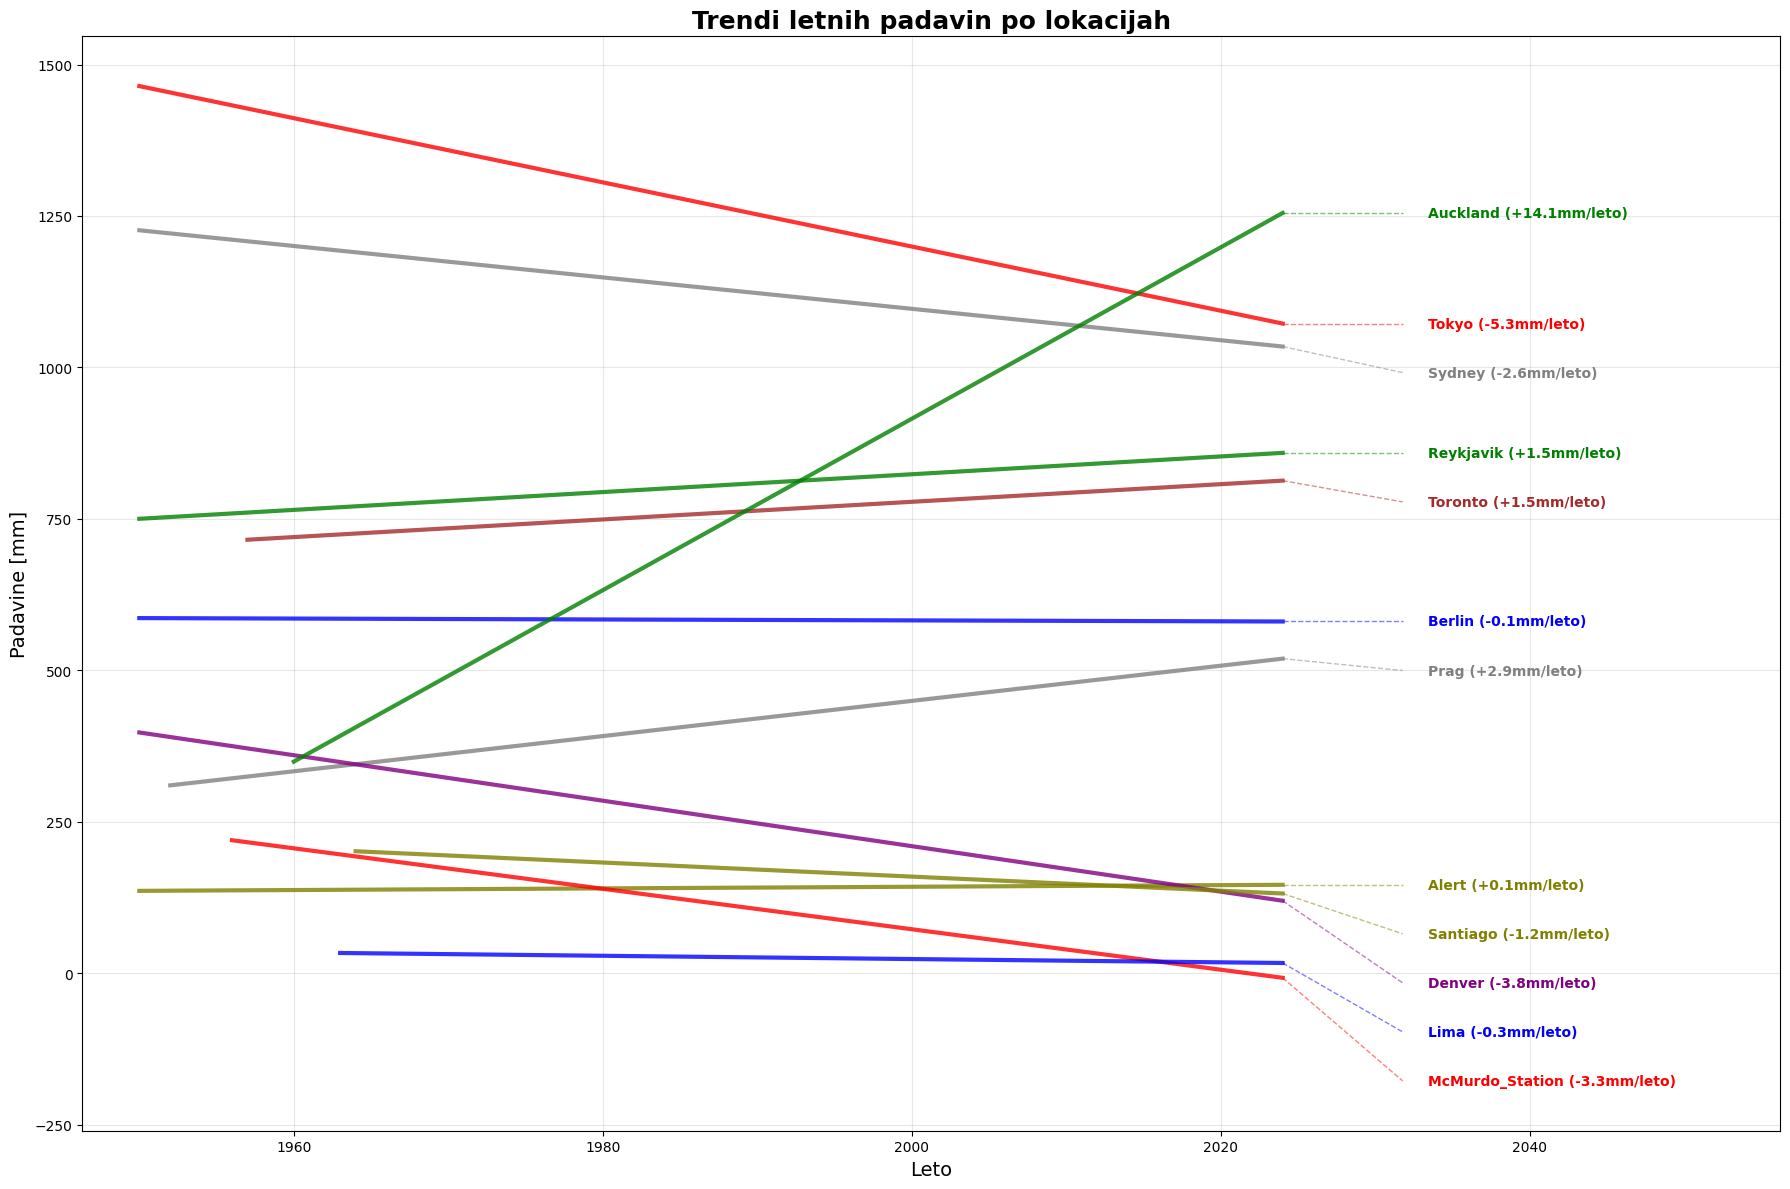

In [37]:
padavine_mesta = []

for mesto, df in podatki_mest.items():
    df['Datum'] = pd.to_datetime(df['time'])
    df['Leto'] = df['Datum'].dt.year
    
    letna_padavina = df.groupby('Leto')[['prcp','snow']].sum().reset_index()
    letna_padavina['Mesto'] = mesto
    padavine_mesta.append(letna_padavina)

df_padavine = pd.concat(padavine_mesta, ignore_index=True)

plt.figure(figsize=(18, 12))

barve = ['red', 'blue', 'green', 'gray', 'olive', 'purple',
        'brown', 'gray', 'red',  'green', 'olive', 'blue']

trendi_padavin = {}

for i, mesto in enumerate(df_padavine['Mesto'].unique()):
    df_tmp = df_padavine[df_padavine['Mesto'] == mesto]
    leta = df_tmp['Leto'].values
    padavine = df_tmp['prcp'].values
    
    if len(leta) > 1 and not np.isnan(padavine).all():

        mask = ~np.isnan(padavine)
        leta_clean = leta[mask]
        padavine_clean = padavine[mask]
        
        if len(leta_clean) > 1:

            naklon, odsek, r_value, p_value, std_err = stats.linregress(leta_clean, padavine_clean)
            trendi_padavin[mesto] = {'naklon': naklon}
            
            barva = barve[i % len(barve)]
            
            x_min, x_max = min(leta_clean), max(leta_clean)
            x_range = np.array([x_min, x_max])
            y_trend = naklon * x_range + odsek
            
            plt.plot(x_range, y_trend, color=barva, linewidth=3, alpha=0.8, label=f'{mesto}')

plt.title('Trendi letnih padavin po lokacijah', fontsize=18, fontweight='bold')
plt.xlabel('Leto', fontsize=14)
plt.ylabel('Padavine [mm]', fontsize=14)
plt.grid(True, alpha=0.3)

ax = plt.gca()
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

desna_meja = x_lim[1] + (x_lim[1] - x_lim[0]) * 0.05
text_margin = (x_lim[1] - x_lim[0]) * 0.02

koncne_vrednosti = {}
for mesto, data in trendi_padavin.items():
    df_tmp = df_padavine[df_padavine['Mesto'] == mesto]
    leta = df_tmp['Leto'].values
    padavine = df_tmp['prcp'].values
    mask = ~np.isnan(padavine)
    if len(leta[mask]) > 0:
        zadnje_leto = max(leta[mask])
        naklon = data['naklon']
        odsek = stats.linregress(leta[mask], padavine[mask]).intercept
        koncne_vrednosti[mesto] = (zadnje_leto, naklon * zadnje_leto + odsek, naklon)

razvrscena_mesta = sorted(koncne_vrednosti.items(), key=lambda x: x[1][1], reverse=True)

min_razmik = (y_lim[1] - y_lim[0]) * 0.05
y_positions = []
current_y = y_lim[1]

for i, (mesto, (leto, koncna_vrednost, naklon)) in enumerate(razvrscena_mesta):
    if i == 0:
        y_positions.append(koncna_vrednost)
        current_y = koncna_vrednost
    else:
        if koncna_vrednost > current_y - min_razmik:
            new_y = current_y - min_razmik
            y_positions.append(new_y)
            current_y = new_y
        else:
            y_positions.append(koncna_vrednost)
            current_y = koncna_vrednost

for i, ((mesto, (leto, koncna_vrednost, naklon)), y_text) in enumerate(zip(razvrscena_mesta, y_positions)):
    barva_idx = list(trendi_padavin.keys()).index(mesto) % len(barve)
    barva = barve[barva_idx]
    
    plt.text(desna_meja + text_margin, y_text, f"{mesto} ({naklon:+.1f}mm/leto)", 
             color=barva, fontsize=10, fontweight='bold',
             verticalalignment='center')
    
    plt.plot([leto, desna_meja], [koncna_vrednost, y_text], 
             color=barva, linewidth=1, alpha=0.5, linestyle='--')

plt.xlim(x_lim[0], desna_meja + (x_lim[1] - x_lim[0]) * 0.3)
plt.tight_layout()
plt.savefig('Podatki/rezultati/trend_letnih_padavin.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.13 Trendi letnih padavin

-  Ustvarimo še tabelo, ki prikazuje trend količine letnih padavin za vsako izmed lokacij.

In [38]:
print("Trendi letnih padavin po lokacijah")
print("=" * 40)
print(f"{'Mesto':<20} {'Trend (+ mm/leto)':<15}")
print("-" * 40)

for mesto, data in sorted(trendi_padavin.items(), key=lambda x: x[1]['naklon'], reverse=True):
    trend_str = f"{data['naklon']:+.2f}"
    print(f"{mesto:<20} {trend_str:<15}")

Trendi letnih padavin po lokacijah
Mesto                Trend (+ mm/leto)
----------------------------------------
Auckland             +14.15         
Prag                 +2.90          
Reykjavik            +1.47          
Toronto              +1.46          
Alert                +0.14          
Berlin               -0.08          
Lima                 -0.27          
Santiago             -1.16          
Sydney               -2.59          
McMurdo_Station      -3.34          
Denver               -3.75          
Tokyo                -5.30          


## 6. Interpretacija rezultatov

**Ključne ugotovitve**:

 - Povprečne letne temperature:
Lahko vidimo da so se med letoma 1950 in 2024 skrajno dvignile izmerjene temperature vseh izbranih lokacij. Najbolj se je segrel Alert, najsevernejše poseljen kraj. Ta meritev je malo dvomljiva, ker ni bilo dosegljivih dovolj podatkov, da bi lahko
ugotovitev siguroma potrdili.

-  Trendi ekstremov:
Opazno je, da se je zdaleč najbolj povečalo število ekstremno hladnih dni na lokaciji McMurdo Stationa na Antarktiki, število ekstremno vročih dni pa narašča na lokaciji prej omenjenega Alerta, kar nadaljnje potrjuje segrevanje.

-  Povprečne letne padavine:
Izmed vseh izbranih lokacij po padavinah izstopa Alert, a trend padavin kaže, da vsako leto (med 1950 in 2024) pade približno enaka količina padavin. Najbolj se povečuje letno povprečje padavin v Aucklandu, kar 1,42 centimetra na leto.

**Omejitve raziskave**:

 -  Na izbran način pridobivanja podatkov, s Meteostat API smo dobili časovno zelo omejeno število podatkov, saj databaze segajo le do leta 1950. Zaradi tega so kakršnekoli ugotovitve nesigurne in neutrjene.

 -  V okviru naloge sem izbral le 12 lokacij, kar ne predstavlja velike raznolikosti podatkov. Za nadaljno delo bi bilo potrebno izbrati lokacije glede na več različnih faktorjev: podnebje, geografska lokacija, urbanost in divjina (zelo težko, saj je večina vremenskih postaj, na katerih je dostopno veliko podatkov v, ali ob velemestu) in drugi.
